### DATA COLLECTION


### A - NCDC Website scrap
Website - https://covid19.ncdc.gov.ng/

In [1]:
# Import all libraries
import os
import glob
import requests
import numpy as np
import urllib.request
import pandas as pd
import csv
from bs4 import BeautifulSoup
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')  
import warnings
warnings.filterwarnings('ignore')

In [2]:
page = requests.get('https://covid19.ncdc.gov.ng')
soup = BeautifulSoup(page.content, 'html.parser')

In [3]:
# After inspecting the source of the above `page`: 
covid_summary = {}

for title, stat in zip(soup.select('h6.text-white'), soup.select('h2 > span')):
    covid_summary[title.text] = stat.text.replace(',', '')
    
covid_summary_S = pd.Series(covid_summary)
covid_summary_S = pd.to_numeric(covid_summary_S)
covid_summary_S

Samples Tested      2093243
Confirmed Cases      166019
Active Cases           7476
Discharged Cases     156476
Death                  2067
dtype: int64

In [4]:
# Create a list containing the column names of the table in the NCDC website
header_list = []

for th in soup.select('th'):
    header_list.append(th.text)
    
header_list

['States Affected',
 'No. of Cases (Lab Confirmed)',
 'No. of Cases (on admission)',
 'No. Discharged',
 'No. of Deaths']

In [5]:
table_data = soup.select('tr')[1:]
data_list = []

for tr in table_data:
    state = tr.select('td')[0].text.strip()
    cases_c = tr.select('td')[1].text.strip()
    cases_a = tr.select('td')[2].text.strip()
    discharged = tr.select('td')[3].text.strip()
    deaths = tr.select('td')[4].text.strip()
    data_list.append([state, cases_c, cases_a, discharged, deaths])

In [6]:
# Save the data to a DataFrame object.
covid_data_states = pd.DataFrame(data_list, columns=header_list)
covid_data_states

,States Affected,No. of Cases (Lab Confirmed),No. of Cases (on admission),No. Discharged,No. of Deaths
0,Lagos,"58,871","1,442","56,990",439
1,FCT,"19,853",581,"19,106",166
2,Kaduna,"9,070",3,"9,002",65
3,Plateau,"9,061",2,"9,002",57
4,Rivers,"7,227",78,"7,048",101
5,Oyo,"6,856",1,"6,731",124
6,Edo,"4,907",2,"4,720",185
7,Ogun,"4,683",3,"4,630",50
8,Kano,"3,981",19,"3,852",110
9,Ondo,"3,283","1,139","2,080",64


In [7]:
os.chdir("/Users/osala/Downloads/Nigeria-COVID-19-Data-Analysis-Using-Python-main")
# Current working directory that contains the dataset and code file

In [8]:
covid_data_states.to_csv("COVID data by state.csv", index=False)

### B - John Hopkins Data Repository
Here you will obtain data from the John Hopkins repository. Your task here involves saving the data from the GitHub repo link to DataFrame for further analysis. Find the links below. 
* Global Daily Confirmed Cases - Click [Here](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv)
* Global Daily Recovered Cases - Click [Here](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv)
* Global Daily Death Cases - Click [Here](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv)

In [9]:
confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed_dly_global = pd.read_csv(confirmed_url)
# Alternatively save web page as a .csv file and open with `.read_csv()`

recovered_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recovered_dly_global = pd.read_csv(recovered_url)

deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deaths_dly_global = pd.read_csv(deaths_url)

### C - External Data 
* Save the external data to a DataFrame
* External Data includes but not limited to: `covid_external.csv`, `Budget data.csv`, `RealGDP.csv`

In [10]:
covid_ext = pd.read_csv('covid_external.csv')
budget = pd.read_csv('Budget data.csv')
gdp = pd.read_csv('RealGDP.csv')

### Task 2 - View the data
Basic information about the data using the `head()` and `info()` method.

* covid_data_states
* confirmed_dly_global
* recovered_dly_global
* deaths_dly_global
* covid_ext
* budget
* gdp

In [ ]:
# What if you loop through the created dataframes, after storing them in a list, and evaluate them using `eval(`)`
# with the `head()` and `info()` methods within the `eval()` code block?
# Yield might also be useful

In [11]:
#covid_data_states.info()
#confirmed_dly_global.info()
#recovered_dly_global.info()
#deaths_dly_global.info()
covid_ext.info()
#budget.info()
#gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   states                   37 non-null     object 
 1   region                   37 non-null     object 
 2   Population               37 non-null     int64  
 3   Overall CCVI Index       37 non-null     float64
 4   Age                      37 non-null     float64
 5   Epidemiological          37 non-null     float64
 6   Fragility                37 non-null     float64
 7   Health System            37 non-null     float64
 8   Population Density       37 non-null     float64
 9   Socio-Economic           37 non-null     float64
 10   Transport Availability  37 non-null     float64
 11  Acute IHR                37 non-null     float64
dtypes: float64(9), int64(1), object(2)
memory usage: 3.6+ KB


In [12]:
#covid_data_states.head()  # For data cleaning below
#confirmed_dly_global.head() # No need for data cleaning
#recovered_dly_global.head() # No need for data cleaning
#deaths_dly_global.head() # No need for data cleaning
covid_ext.head()
#budget.head()
#gdp.head() # No need for data cleaning after inspection


,states,region,Population,Overall CCVI Index,Age,Epidemiological,Fragility,Health System,Population Density,Socio-Economic,Transport Availability,Acute IHR
0,FCT,North Central,4865000,0.3,0.0,0.9,0.4,0.6,0.9,0.6,0.2,0.79
1,Plateau,North Central,4766000,0.4,0.5,0.4,0.8,0.3,0.3,0.5,0.3,0.93
2,Kwara,North Central,3524000,0.3,0.4,0.3,0.2,0.4,0.2,0.6,0.7,0.93
3,Nassarawa,North Central,2783000,0.1,0.3,0.5,0.9,0.0,0.1,0.6,0.5,0.85
4,Niger,North Central,6260000,0.6,0.0,0.6,0.3,0.7,0.1,0.8,0.8,0.84


### Task 3 - Data Cleaning and Preparation 
* Convert to appropriate data type.
* Rename the columns of the scraped data.
* Remove comma(,) in numerical data
* Extract daily data for Nigeria from the Global daily cases data

A - Clean the scraped data

In [13]:
# replace commas in the columns containing numbers from the `covid_data_states` dataframe
for column in covid_data_states.iloc[:,1:]:
    covid_data_states[column] = covid_data_states[column].replace({',': ''}, regex=True)
    
# convert the columns containing numbers to the appropriate data type
for column in covid_data_states.iloc[:,1:]:
    covid_data_states[column] = pd.to_numeric(covid_data_states[column])
    
covid_data_states.info()
covid_data_states

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   States Affected               37 non-null     object
 1   No. of Cases (Lab Confirmed)  37 non-null     int64 
 2   No. of Cases (on admission)   37 non-null     int64 
 3   No. Discharged                37 non-null     int64 
 4   No. of Deaths                 37 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 1.6+ KB


,States Affected,No. of Cases (Lab Confirmed),No. of Cases (on admission),No. Discharged,No. of Deaths
0,Lagos,58871,1442,56990,439
1,FCT,19853,581,19106,166
2,Kaduna,9070,3,9002,65
3,Plateau,9061,2,9002,57
4,Rivers,7227,78,7048,101
5,Oyo,6856,1,6731,124
6,Edo,4907,2,4720,185
7,Ogun,4683,3,4630,50
8,Kano,3981,19,3852,110
9,Ondo,3283,1139,2080,64


B - Get a Pandas DataFrame for Daily Confirmed Cases in Nigeria. Column names are `Date` and `No of Cases`

In [14]:
bool_c = confirmed_dly_global['Country/Region'] == 'Nigeria'
confirmed_dly_nigeria = confirmed_dly_global.loc[bool_c]
confirmed_dly_nigeria = confirmed_dly_nigeria.iloc[:, 4:]

confirmed_dly_nigeria_list = []
for date, case in zip(list(confirmed_dly_nigeria.columns), list(confirmed_dly_nigeria.values)[0]):
    confirmed_dly_nigeria_list.append([date, case])
# A list comprehension could also be used for the above

confirmed_dly_nigeria = pd.DataFrame(confirmed_dly_nigeria_list, columns=['Date', 'No of Cases'])
confirmed_dly_nigeria['Date'] = pd.to_datetime(confirmed_dly_nigeria['Date'])
confirmed_dly_nigeria

,Date,No of Cases
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0
...,...,...
484,2021-05-20,165901
485,2021-05-21,165944
486,2021-05-22,165979
487,2021-05-23,166019


C - Get a Pandas DataFrame for Daily Recovered Cases in Nigeria. Columns are Date and Cases

In [15]:
bool_r = recovered_dly_global['Country/Region'] == 'Nigeria'
recovered_dly_nigeria = recovered_dly_global.loc[bool_r]
recovered_dly_nigeria = recovered_dly_nigeria.iloc[:, 4:]

recovered_dly_nigeria_list = [[date, case] for date, case in zip(list(recovered_dly_nigeria.columns), 
                                                                 list(recovered_dly_nigeria.values)[0])]

recovered_dly_nigeria = pd.DataFrame(recovered_dly_nigeria_list, columns=['Date', 'No of Cases'])
recovered_dly_nigeria['Date'] = pd.to_datetime(recovered_dly_nigeria['Date'])
recovered_dly_nigeria

,Date,No of Cases
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0
...,...,...
484,2021-05-20,156459
485,2021-05-21,156462
486,2021-05-22,156468
487,2021-05-23,156476


D - Get a Pandas DataFrame for Daily Death Cases in Nigeria. Columns are Date and Cases

In [17]:
bool_d = deaths_dly_global['Country/Region'] == 'Nigeria'
deaths_dly_nigeria = deaths_dly_global.loc[bool_d]
deaths_dly_nigeria = deaths_dly_global.iloc[:, 4:]

deaths_dly_nigeria_list = [[date, case] for date, case in zip(deaths_dly_nigeria.columns.tolist(), 
                                                                 deaths_dly_nigeria.values[0].tolist())]

deaths_dly_nigeria = pd.DataFrame(deaths_dly_nigeria_list, columns=['Date', 'No of Cases'])
deaths_dly_nigeria['Date'] = pd.to_datetime(deaths_dly_nigeria['Date'])
deaths_dly_nigeria

,Date,No of Cases
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0
...,...,...
484,2021-05-20,2772
485,2021-05-21,2782
486,2021-05-22,2792
487,2021-05-23,2802


### Task 4 - Analysis
Here I will perform some analyses on the datasets
<br>

* Here is a pie chart showing a summary of Nigeria's COVID-19 data 

<AxesSubplot:title={'center':"SUMMARY OF NIGERIA'S COVID-19 DATA, CASES AND OUTCOMES"}>

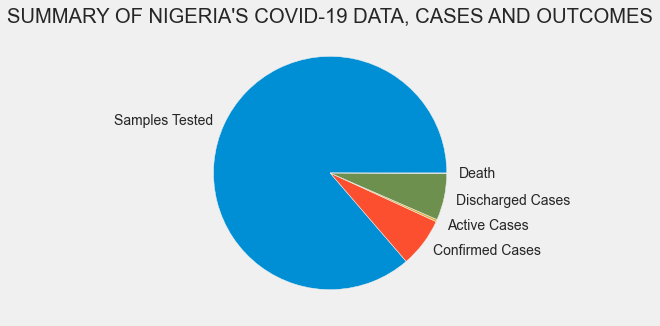

In [18]:
covid_summary_S.plot(kind='pie', ylabel='', figsize= (8,5), title= "SUMMARY OF NIGERIA'S COVID-19 DATA, CASES AND OUTCOMES")

A - Generate a plot that shows the top 10 states in terms of confirmed COVID-19 cases by laboratory test

In [19]:
top_10_confirmed = covid_data_states.nlargest(10, 'No. of Cases (Lab Confirmed)')
top_10_confirmed

,States Affected,No. of Cases (Lab Confirmed),No. of Cases (on admission),No. Discharged,No. of Deaths
0,Lagos,58871,1442,56990,439
1,FCT,19853,581,19106,166
2,Kaduna,9070,3,9002,65
3,Plateau,9061,2,9002,57
4,Rivers,7227,78,7048,101
5,Oyo,6856,1,6731,124
6,Edo,4907,2,4720,185
7,Ogun,4683,3,4630,50
8,Kano,3981,19,3852,110
9,Ondo,3283,1139,2080,64


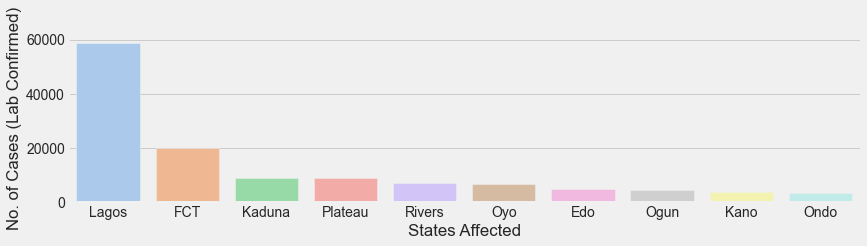

In [20]:
sns.catplot(x="States Affected", y="No. of Cases (Lab Confirmed)", kind='bar', aspect=4, height=3, palette='pastel',
                  data=top_10_confirmed)

B - Generate a plot that shows the Top 10 states in terms of Discharged Covid cases.

In [21]:
top_10_discharged = covid_data_states.nlargest(10, 'No. Discharged')
top_10_discharged

,States Affected,No. of Cases (Lab Confirmed),No. of Cases (on admission),No. Discharged,No. of Deaths
0,Lagos,58871,1442,56990,439
1,FCT,19853,581,19106,166
2,Kaduna,9070,3,9002,65
3,Plateau,9061,2,9002,57
4,Rivers,7227,78,7048,101
5,Oyo,6856,1,6731,124
6,Edo,4907,2,4720,185
7,Ogun,4683,3,4630,50
8,Kano,3981,19,3852,110
10,Kwara,3123,1,3067,55


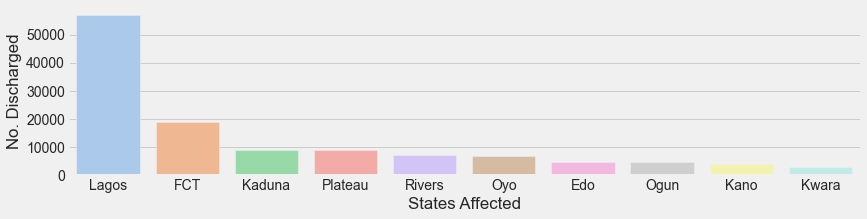

In [22]:
sns.catplot(x="States Affected", y="No. Discharged", kind='bar', aspect=4, height=3, palette='pastel',
                  data=top_10_discharged)


D - Plot the top 10 Death cases

In [23]:
top_10_deaths = covid_data_states.nlargest(10, 'No. of Deaths')
top_10_deaths

,States Affected,No. of Cases (Lab Confirmed),No. of Cases (on admission),No. Discharged,No. of Deaths
0,Lagos,58871,1442,56990,439
6,Edo,4907,2,4720,185
1,FCT,19853,581,19106,166
5,Oyo,6856,1,6731,124
8,Kano,3981,19,3852,110
4,Rivers,7227,78,7048,101
11,Delta,2627,812,1744,71
2,Kaduna,9070,3,9002,65
9,Ondo,3283,1139,2080,64
3,Plateau,9061,2,9002,57


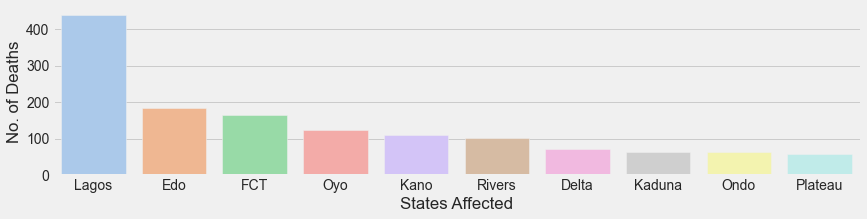

In [24]:
sns.catplot(x="States Affected", y="No. of Deaths", kind='bar', aspect=4, height=3, palette='pastel',
                  data=top_10_deaths)

E - Generate a line plot for the total daily confirmed, recovered and death cases in Nigeria

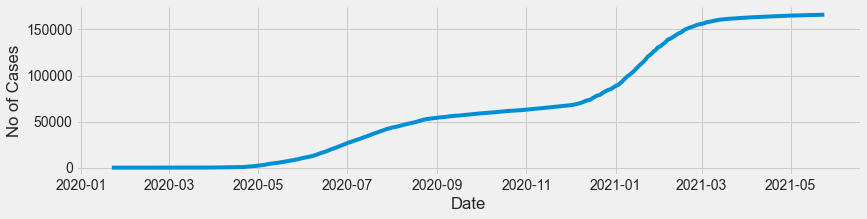

In [25]:
confirmed_chart = sns.relplot(
    data=confirmed_dly_nigeria, kind="line",
    x="Date", y="No of Cases", aspect=4, height=3, palette='pastel')

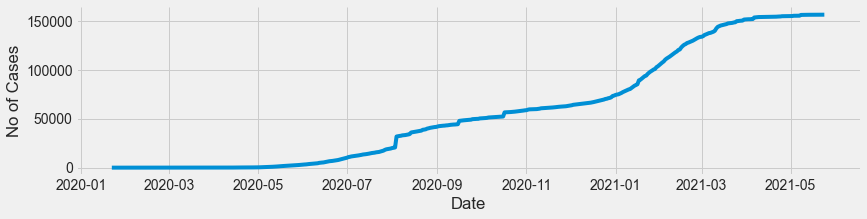

In [26]:
recovered_chart = sns.relplot(
    data=recovered_dly_nigeria, kind="line",
    x="Date", y="No of Cases", aspect=4, height=3, palette='pastel')

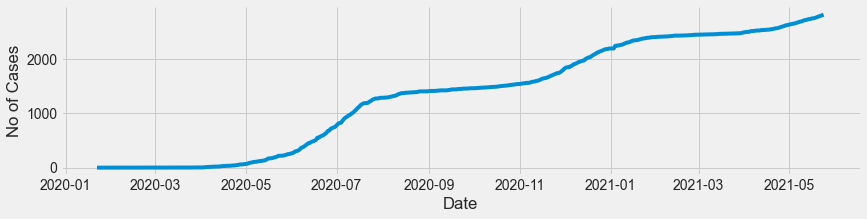

In [27]:
sns.relplot(
    data=deaths_dly_nigeria, kind="line",
    x="Date", y="No of Cases", aspect=4, height=3, palette='pastel')

TODO F - 
* Determine the daily infection rate, you can use the Pandas `diff` method to find the derivate of the total cases.
* Generate a line plot for the above

In [28]:
confirmed_dly_nigeria['Daily Cases'] = confirmed_dly_nigeria['No of Cases'].diff()
confirmed_dly_nigeria

,Date,No of Cases,Daily Cases
0,2020-01-22,0,NaN
1,2020-01-23,0,0.0
2,2020-01-24,0,0.0
3,2020-01-25,0,0.0
4,2020-01-26,0,0.0
...,...,...,...
484,2021-05-20,165901,49.0
485,2021-05-21,165944,43.0
486,2021-05-22,165979,35.0
487,2021-05-23,166019,40.0


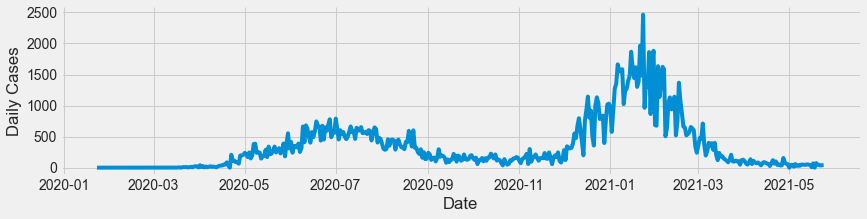

In [29]:
sns.relplot(
    data=confirmed_dly_nigeria, kind="line",
    x="Date", y="Daily Cases", aspect=4, height=3, palette='pastel')

In [30]:
recovered_dly_nigeria['Daily Cases'] = recovered_dly_nigeria['No of Cases'].diff()
recovered_dly_nigeria

,Date,No of Cases,Daily Cases
0,2020-01-22,0,NaN
1,2020-01-23,0,0.0
2,2020-01-24,0,0.0
3,2020-01-25,0,0.0
4,2020-01-26,0,0.0
...,...,...,...
484,2021-05-20,156459,3.0
485,2021-05-21,156462,3.0
486,2021-05-22,156468,6.0
487,2021-05-23,156476,8.0


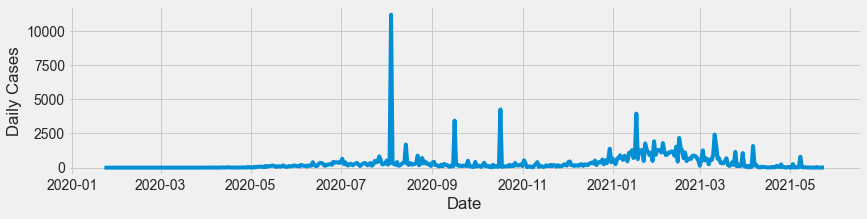

In [31]:
sns.relplot(
    data=recovered_dly_nigeria, kind="line",
    x="Date", y="Daily Cases", aspect=4, height=3, palette='pastel')

In [32]:
deaths_dly_nigeria['Daily Cases'] = deaths_dly_nigeria['No of Cases'].diff()
deaths_dly_nigeria

,Date,No of Cases,Daily Cases
0,2020-01-22,0,NaN
1,2020-01-23,0,0.0
2,2020-01-24,0,0.0
3,2020-01-25,0,0.0
4,2020-01-26,0,0.0
...,...,...,...
484,2021-05-20,2772,10.0
485,2021-05-21,2782,10.0
486,2021-05-22,2792,10.0
487,2021-05-23,2802,10.0


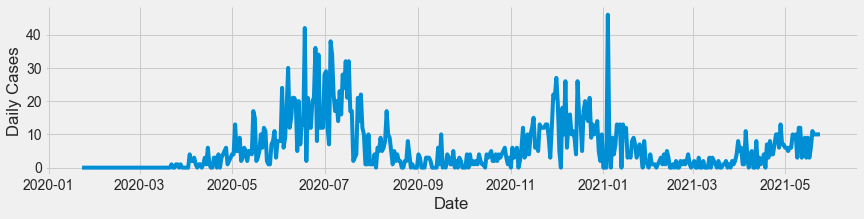

In [33]:
sns.relplot(
    data=deaths_dly_nigeria, kind="line",
    x="Date", y="Daily Cases", aspect=4, height=3, palette='pastel')

G - 
* Calculate maximum infection rate for a day (Number of new cases)
* Find the date

In [34]:
confirmed_dly_nigeria.iloc[confirmed_dly_nigeria['Daily Cases'].idxmax()]

Date           2021-01-23 00:00:00
No of Cases                 120602
Daily Cases                   2464
Name: 367, dtype: object

**Maximum infection rate for a day is 2464 on the 23rd of January, 2021**

In [35]:
recovered_dly_nigeria.iloc[recovered_dly_nigeria['Daily Cases'].idxmax()]

Date           2020-08-04 00:00:00
No of Cases                  31851
Daily Cases                  11188
Name: 195, dtype: object

**The maximum no of recoveries in a day is 11,188 on the 4th of August, 2020**

In [36]:
deaths_dly_nigeria.iloc[deaths_dly_nigeria['Daily Cases'].idxmax()]

Date           2021-01-04 00:00:00
No of Cases                   2237
Daily Cases                     46
Name: 348, dtype: object

**The maximum daily death rate, 46, occurred on the 4th of January, 2021**

TODO H - Determine the relationship between the external dataset and the NCDC COVID-19 dataset. 
Here you will generate a line plot of top 10 confirmed cases and the overall community vulnerability index on the same axis. From the graph, explain your observation.
<br>
Steps
* Combine the two dataset together on a common column(states)

In [37]:
# Correct the spelling errors within the `covid_ext['states']` column
covid_ext.iloc[[3,30], 0] = ['Nasarawa', 'Cross River']

# Rename the `States Affected` and `states` columns to `States` in both dataframes
covid_data_states.rename(columns={'States Affected': 'States'}, inplace=True)
covid_ext.rename(columns={'states': 'States'}, inplace=True)



# Merge both dataframes using `pd.merge()`
covid_states_external = pd.merge(covid_data_states, covid_ext, how='outer', on='States')

covid_states_external.info()
covid_states_external

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 0 to 36
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   States                        37 non-null     object 
 1   No. of Cases (Lab Confirmed)  37 non-null     int64  
 2   No. of Cases (on admission)   37 non-null     int64  
 3   No. Discharged                37 non-null     int64  
 4   No. of Deaths                 37 non-null     int64  
 5   region                        37 non-null     object 
 6   Population                    37 non-null     int64  
 7   Overall CCVI Index            37 non-null     float64
 8   Age                           37 non-null     float64
 9   Epidemiological               37 non-null     float64
 10  Fragility                     37 non-null     float64
 11  Health System                 37 non-null     float64
 12  Population Density            37 non-null     float64
 13  Socio-E

,States,No. of Cases (Lab Confirmed),No. of Cases (on admission),No. Discharged,No. of Deaths,region,Population,Overall CCVI Index,Age,Epidemiological,Fragility,Health System,Population Density,Socio-Economic,Transport Availability,Acute IHR
0,Lagos,58871,1442,56990,439,South West,13992000,0.0,0.1,1.0,0.3,0.1,1.0,0.1,0.4,0.93
1,FCT,19853,581,19106,166,North Central,4865000,0.3,0.0,0.9,0.4,0.6,0.9,0.6,0.2,0.79
2,Kaduna,9070,3,9002,65,North West,9227000,0.7,0.1,0.9,0.8,0.9,0.4,0.6,0.4,0.86
3,Plateau,9061,2,9002,57,North Central,4766000,0.4,0.5,0.4,0.8,0.3,0.3,0.5,0.3,0.93
4,Rivers,7227,78,7048,101,South South,7763000,0.4,0.5,0.9,0.6,0.6,0.9,0.1,0.1,1.00
5,Oyo,6856,1,6731,124,South West,8737000,0.2,0.7,0.8,0.2,0.8,0.6,0.2,0.3,1.06
6,Edo,4907,2,4720,185,South South,4705000,0.1,0.9,0.8,0.1,0.1,0.5,0.4,0.3,1.09
7,Ogun,4683,3,4630,50,South West,5878000,0.3,0.6,0.7,0.5,0.6,0.6,0.0,0.2,1.07
8,Kano,3981,19,3852,110,North West,14726000,0.6,0.2,0.1,0.3,0.4,0.8,0.8,0.5,0.87
9,Ondo,3283,1139,2080,64,South West,5185000,0.1,0.8,0.5,0.1,0.3,0.6,0.3,0.3,1.04


In [38]:
top_10_confirmed_external = covid_states_external.nlargest(10, 'No. of Cases (Lab Confirmed)')
top_10_confirmed_external

,States,No. of Cases (Lab Confirmed),No. of Cases (on admission),No. Discharged,No. of Deaths,region,Population,Overall CCVI Index,Age,Epidemiological,Fragility,Health System,Population Density,Socio-Economic,Transport Availability,Acute IHR
0,Lagos,58871,1442,56990,439,South West,13992000,0.0,0.1,1.0,0.3,0.1,1.0,0.1,0.4,0.93
1,FCT,19853,581,19106,166,North Central,4865000,0.3,0.0,0.9,0.4,0.6,0.9,0.6,0.2,0.79
2,Kaduna,9070,3,9002,65,North West,9227000,0.7,0.1,0.9,0.8,0.9,0.4,0.6,0.4,0.86
3,Plateau,9061,2,9002,57,North Central,4766000,0.4,0.5,0.4,0.8,0.3,0.3,0.5,0.3,0.93
4,Rivers,7227,78,7048,101,South South,7763000,0.4,0.5,0.9,0.6,0.6,0.9,0.1,0.1,1.00
5,Oyo,6856,1,6731,124,South West,8737000,0.2,0.7,0.8,0.2,0.8,0.6,0.2,0.3,1.06
6,Edo,4907,2,4720,185,South South,4705000,0.1,0.9,0.8,0.1,0.1,0.5,0.4,0.3,1.09
7,Ogun,4683,3,4630,50,South West,5878000,0.3,0.6,0.7,0.5,0.6,0.6,0.0,0.2,1.07
8,Kano,3981,19,3852,110,North West,14726000,0.6,0.2,0.1,0.3,0.4,0.8,0.8,0.5,0.87
9,Ondo,3283,1139,2080,64,South West,5185000,0.1,0.8,0.5,0.1,0.3,0.6,0.3,0.3,1.04


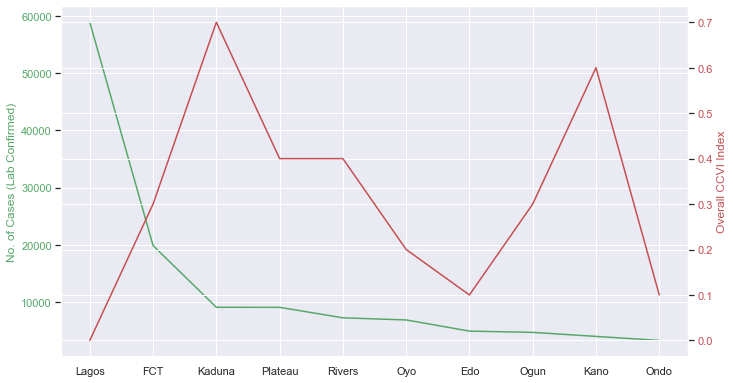

In [39]:
dark_grid_style = sns.set_theme(style="darkgrid")

fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(111)
ax1.plot(top_10_confirmed_external['States'], top_10_confirmed_external['No. of Cases (Lab Confirmed)'], 'g-')
ax1.set_ylabel('No. of Cases (Lab Confirmed)', color='g')
for tl in ax1.get_yticklabels():
    tl.set_color('g')

ax2 = ax1.twinx()
ax2.plot(top_10_confirmed_external['States'], top_10_confirmed_external['Overall CCVI Index'], 'r-')
ax2.set_ylabel('Overall CCVI Index', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

Text(0, 0.5, 'Overall CCVI Index')

<Figure size 432x288 with 0 Axes>

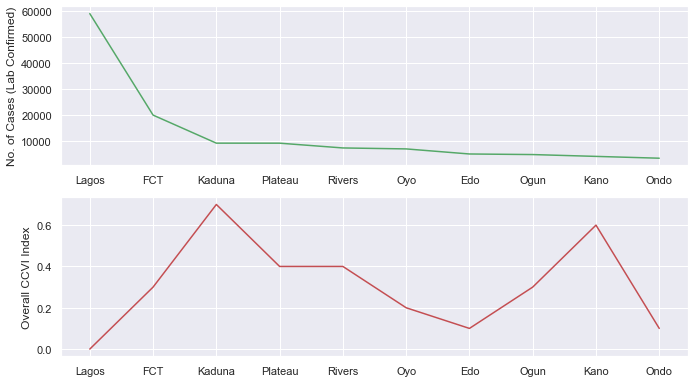

In [40]:
dark_grid_style

plt.figure()
f, axes = plt.subplots(2, 1, figsize = (10,6))
axes[0].plot(top_10_confirmed_external['States'], top_10_confirmed_external['No. of Cases (Lab Confirmed)'], 'g-')
axes[0].set_ylabel('No. of Cases (Lab Confirmed)')

axes[1].plot(top_10_confirmed_external['States'], top_10_confirmed_external['Overall CCVI Index'], 'r-')
axes[1].set_ylabel('Overall CCVI Index')

In [41]:
top_10_discharged_external = covid_states_external.nlargest(10, 'No. Discharged')
top_10_discharged_external

,States,No. of Cases (Lab Confirmed),No. of Cases (on admission),No. Discharged,No. of Deaths,region,Population,Overall CCVI Index,Age,Epidemiological,Fragility,Health System,Population Density,Socio-Economic,Transport Availability,Acute IHR
0,Lagos,58871,1442,56990,439,South West,13992000,0.0,0.1,1.0,0.3,0.1,1.0,0.1,0.4,0.93
1,FCT,19853,581,19106,166,North Central,4865000,0.3,0.0,0.9,0.4,0.6,0.9,0.6,0.2,0.79
2,Kaduna,9070,3,9002,65,North West,9227000,0.7,0.1,0.9,0.8,0.9,0.4,0.6,0.4,0.86
3,Plateau,9061,2,9002,57,North Central,4766000,0.4,0.5,0.4,0.8,0.3,0.3,0.5,0.3,0.93
4,Rivers,7227,78,7048,101,South South,7763000,0.4,0.5,0.9,0.6,0.6,0.9,0.1,0.1,1.00
5,Oyo,6856,1,6731,124,South West,8737000,0.2,0.7,0.8,0.2,0.8,0.6,0.2,0.3,1.06
6,Edo,4907,2,4720,185,South South,4705000,0.1,0.9,0.8,0.1,0.1,0.5,0.4,0.3,1.09
7,Ogun,4683,3,4630,50,South West,5878000,0.3,0.6,0.7,0.5,0.6,0.6,0.0,0.2,1.07
8,Kano,3981,19,3852,110,North West,14726000,0.6,0.2,0.1,0.3,0.4,0.8,0.8,0.5,0.87
10,Kwara,3123,1,3067,55,North Central,3524000,0.3,0.4,0.3,0.2,0.4,0.2,0.6,0.7,0.93


Text(0, 0.5, 'Overall CCVI Index')

<Figure size 432x288 with 0 Axes>

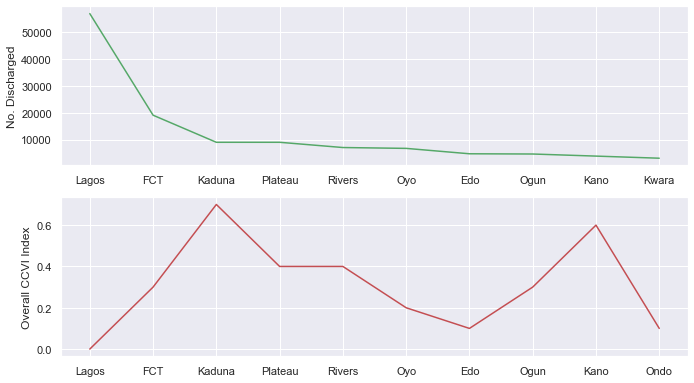

In [42]:

plt.figure()
f, axes = plt.subplots(2, 1, figsize = (10,6))
axes[0].plot(top_10_discharged_external['States'], top_10_discharged_external['No. Discharged'], 'g-')
axes[0].set_ylabel('No. Discharged')

axes[1].plot(top_10_confirmed_external['States'], top_10_confirmed_external['Overall CCVI Index'], 'r-')
axes[1].set_ylabel('Overall CCVI Index')

In [43]:
top_10_deaths_external = covid_states_external.nlargest(10, 'No. of Deaths')
top_10_deaths_external

,States,No. of Cases (Lab Confirmed),No. of Cases (on admission),No. Discharged,No. of Deaths,region,Population,Overall CCVI Index,Age,Epidemiological,Fragility,Health System,Population Density,Socio-Economic,Transport Availability,Acute IHR
0,Lagos,58871,1442,56990,439,South West,13992000,0.0,0.1,1.0,0.3,0.1,1.0,0.1,0.4,0.93
6,Edo,4907,2,4720,185,South South,4705000,0.1,0.9,0.8,0.1,0.1,0.5,0.4,0.3,1.09
1,FCT,19853,581,19106,166,North Central,4865000,0.3,0.0,0.9,0.4,0.6,0.9,0.6,0.2,0.79
5,Oyo,6856,1,6731,124,South West,8737000,0.2,0.7,0.8,0.2,0.8,0.6,0.2,0.3,1.06
8,Kano,3981,19,3852,110,North West,14726000,0.6,0.2,0.1,0.3,0.4,0.8,0.8,0.5,0.87
4,Rivers,7227,78,7048,101,South South,7763000,0.4,0.5,0.9,0.6,0.6,0.9,0.1,0.1,1.00
11,Delta,2627,812,1744,71,South South,6303000,0.4,0.6,0.7,0.2,1.0,0.6,0.5,0.4,1.08
2,Kaduna,9070,3,9002,65,North West,9227000,0.7,0.1,0.9,0.8,0.9,0.4,0.6,0.4,0.86
9,Ondo,3283,1139,2080,64,South West,5185000,0.1,0.8,0.5,0.1,0.3,0.6,0.3,0.3,1.04
3,Plateau,9061,2,9002,57,North Central,4766000,0.4,0.5,0.4,0.8,0.3,0.3,0.5,0.3,0.93


Text(0, 0.5, 'Overall CCVI Index')

<Figure size 432x288 with 0 Axes>

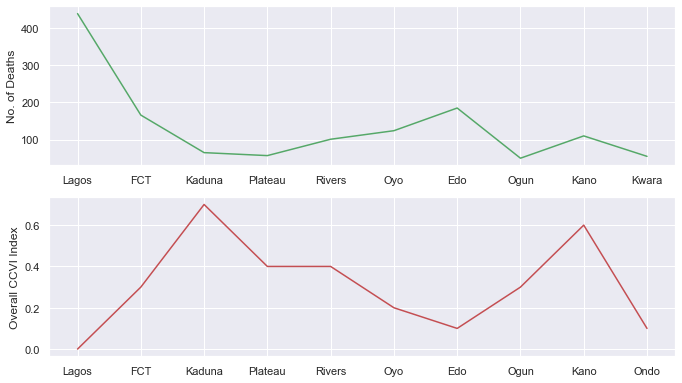

In [44]:

plt.figure()
f, axes = plt.subplots(2, 1, figsize = (10,6))
axes[0].plot(top_10_discharged_external['States'], top_10_discharged_external['No. of Deaths'], 'g-')
axes[0].set_ylabel('No. of Deaths')

axes[1].plot(top_10_confirmed_external['States'], top_10_confirmed_external['Overall CCVI Index'], 'r-')
axes[1].set_ylabel('Overall CCVI Index')

I - Determine the relationship between the external dataset and the NCDC COVID-19 dataset. 
* Here you will generate a regression plot between two variables to visualize the linear relationships - Confirmed Cases and Population Density.
* Provide a summary of your observation

<AxesSubplot:xlabel='Population Density', ylabel='No. of Cases (Lab Confirmed)'>

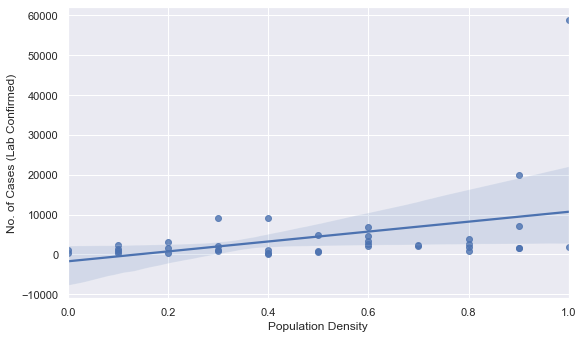

In [45]:
plt.subplots(figsize = (8,5))
sns.regplot(y='No. of Cases (Lab Confirmed)', x='Population Density',
            data=covid_states_external)

<AxesSubplot:xlabel='Population Density', ylabel='No. Discharged'>

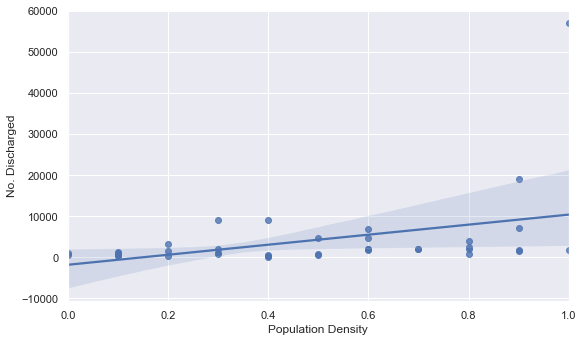

In [46]:
plt.subplots(figsize = (8,5))
sns.regplot(y='No. Discharged', x='Population Density',
            data=covid_states_external)

<AxesSubplot:xlabel='Population Density', ylabel='No. of Deaths'>

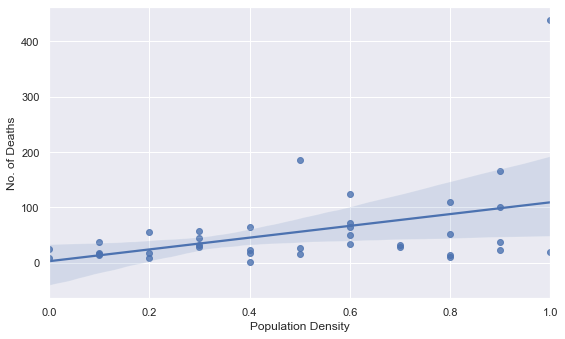

In [47]:
plt.subplots(figsize = (8,5))
sns.regplot(y='No. of Deaths', x='Population Density',
            data=covid_states_external)

TODO J - 
* Provide more analyses by extending TODO G & H. Meaning, determine relationships between more features.
* Provide a detailed summary of your findings. 
* Note that you can have as many as possible.

### TODO L - 
Determine the effect of the Pandemic on the economy. To do this, you will compare the Real GDP value Pre-COVID-19 with Real GDP in 2020 (COVID-19 Period, especially Q2 2020)
<br>
Steps
* From the Real GDP Data, generate a `barplot` using the GDP values for each year & quarters. For example: On x-axis you will have year 2017 and the bars will be values of each quarters(Q1-Q4). You expected to have subplots of each quarters on one graph.
<br>
Hint: Use [Pandas.melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) to create your plot DataFrame 
* Set your quarter legend to lower left.
* Using `axhline`, draw a horizontal line through the graph at the value of Q2 2020.
* Write out your observation

In [48]:
# Melt the `gdp` dataframe and sort by the `Year` and `GDP value` columns 
melted_gdp = gdp.melt(['Year'], var_name='Quarter', value_name='GDP value').sort_values(['Year', 'Quarter'])
melted_gdp

,Year,Quarter,GDP value
0,2014,Q1,15438679.50
7,2014,Q2,16084622.31
14,2014,Q3,17479127.58
21,2014,Q4,18150356.45
1,2015,Q1,16050601.38
8,2015,Q2,16463341.91
15,2015,Q3,17976234.59
22,2015,Q4,18533752.07
2,2016,Q1,15943714.54
9,2016,Q2,16218542.41


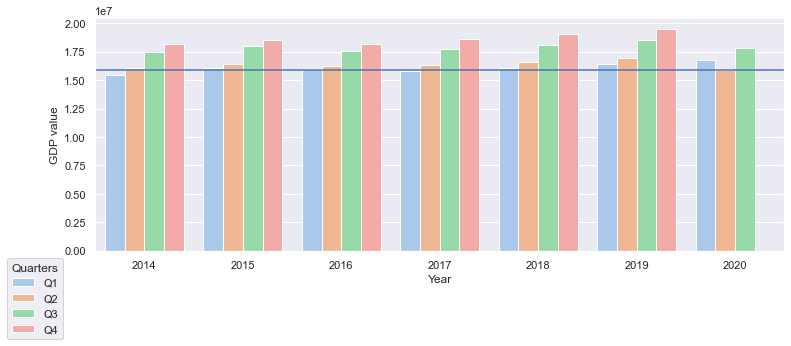

In [49]:
plt.subplots(figsize = (11,4))
gdp_g = sns.barplot(x="Year", y="GDP value", hue='Quarter', palette='pastel',
                  data=melted_gdp)
gdp_g.legend(loc=3, title='Quarters', borderaxespad=-8)
gdp_g.axhline(15890000.00) # value of Q2 2020

### Note: Do not limit your analysis to the provided TODOs. Perform more analyses e.g 
* Check for more external dataset
* Ask more questions & find the right answers by exploring the data